In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from pandas.plotting import parallel_coordinates
from IPython.display import display

In [123]:
# Load CSV
df = pd.read_csv(r"/results/sweep_results_20_input_der.csv")

# Automatically detect lambda columns and metric columns
lambda_cols = [col for col in df.columns if col.startswith("lambda_")]
accuracy_cols = [col for col in df.columns if "accuracy" in col]
loss_cols = [col for col in df.columns if "loss" in col]
expert_usage_cols = [col for col in df.columns if "expert_" in col and "usage" in col]
gating_cols = [col for col in df.columns if "gating" in col]
ending_epoch = df["epoch_end"]
regression_metrics = [col for col in df.columns if col in ["test_MSE", "test_MAE", "test_R2_t_0", "test_R2_t_end"]]

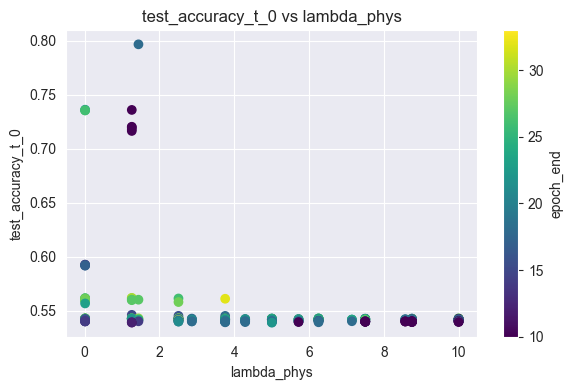

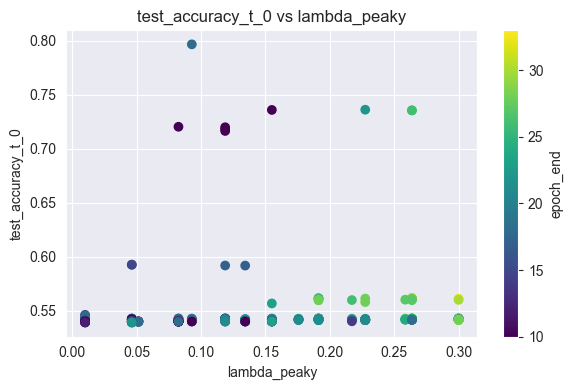

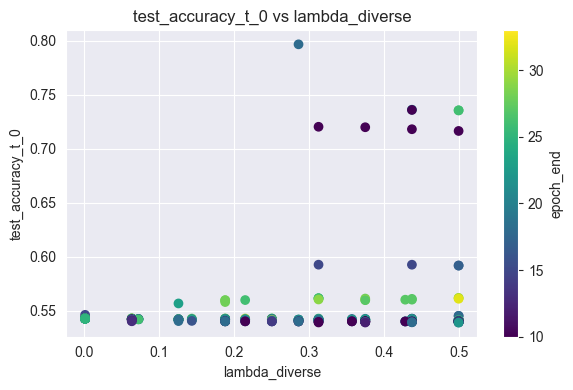

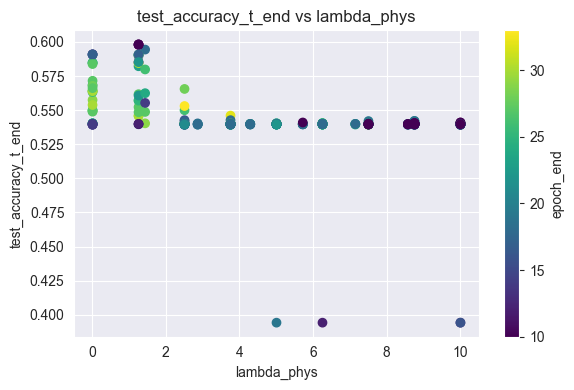

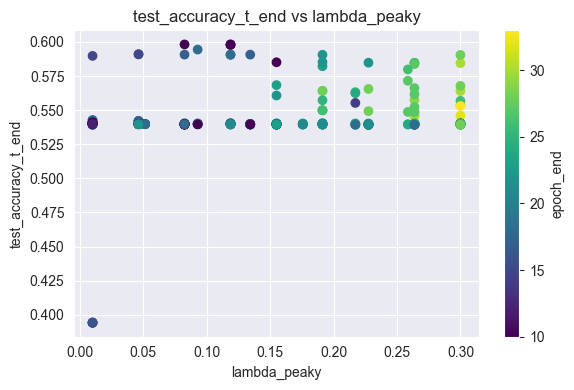

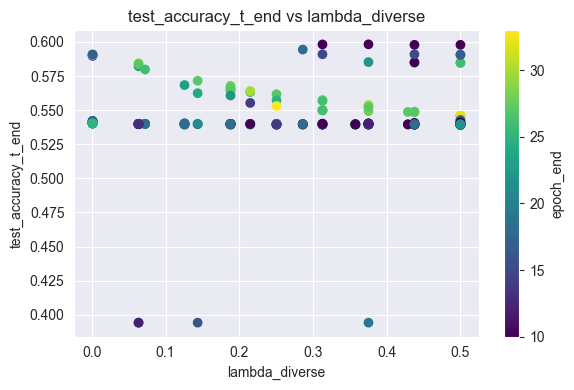

In [124]:
## 1. Accuracy vs Lambda Scatter Plots
def plot_lambda_vs_metric(df, metric="test_accuracy_t_0"):
    for lam in lambda_cols:
        fig, ax = plt.subplots(figsize=(6, 4))
        sc = ax.scatter(
            df[lam], df[metric],
            c=df["epoch_end"],
            cmap="viridis"
        )
        ax.set_title(f"{metric} vs {lam}")
        ax.set_xlabel(lam)
        ax.set_ylabel(metric)

        # Add colorbar
        cbar = plt.colorbar(sc, ax=ax)
        cbar.set_label("epoch_end")

        plt.tight_layout()
        plt.show()


plot_lambda_vs_metric(df, "test_accuracy_t_0")
plot_lambda_vs_metric(df, "test_accuracy_t_end")


In [125]:
## 2. 3D Scatter of Lambdas vs Accuracy
vmin, vmax = df["test_accuracy_t_0"].quantile([0.05, 0.95])


fig = px.scatter_3d(df, x=lambda_cols[0], y=lambda_cols[1], z=lambda_cols[2],
                    color="test_accuracy_t_0", hover_data=["run_id"], range_color=(vmin, vmax))
fig.update_layout(title="3D Lambda Space Colored by test_accuracy_t_0")
fig.show()

vmin, vmax = df["test_accuracy_t_end"].quantile([0.05, 0.95])
fig = px.scatter_3d(df, x=lambda_cols[0], y=lambda_cols[1], z=lambda_cols[2],
                    color="test_accuracy_t_end", hover_data=["run_id"], range_color=(vmin, vmax))
fig.update_layout(title="3D Lambda Space Colored by test_accuracy_t_end")
fig.show()

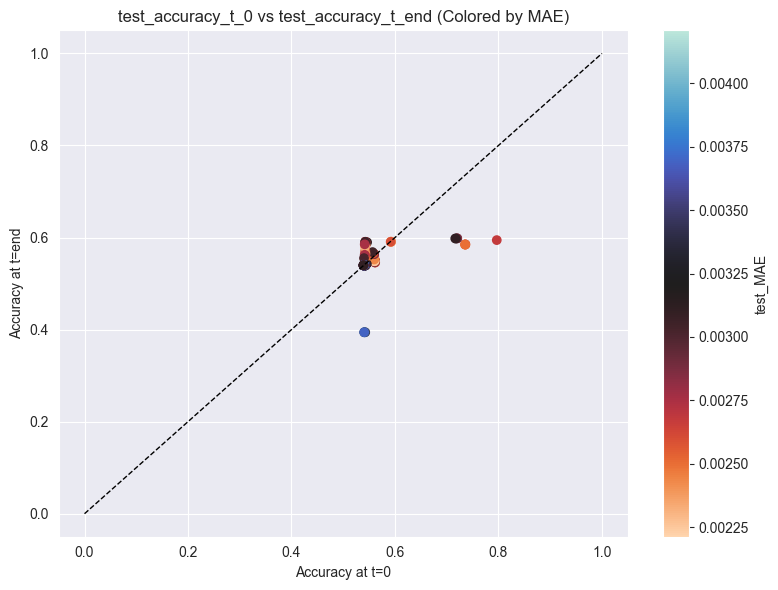

In [126]:
## 3. Accuracy vs Generalization (Overfitting Insight)
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(
    df["test_accuracy_t_0"],
    df["test_accuracy_t_end"],
    c=df["test_MAE"],
    cmap="icefire_r"
)
ax.plot([0, 1], [0, 1], 'k--', lw=1)
ax.set_title("test_accuracy_t_0 vs test_accuracy_t_end (Colored by MAE)")
ax.set_xlabel("Accuracy at t=0")
ax.set_ylabel("Accuracy at t=end")

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("test_MAE")

plt.tight_layout()
plt.show()


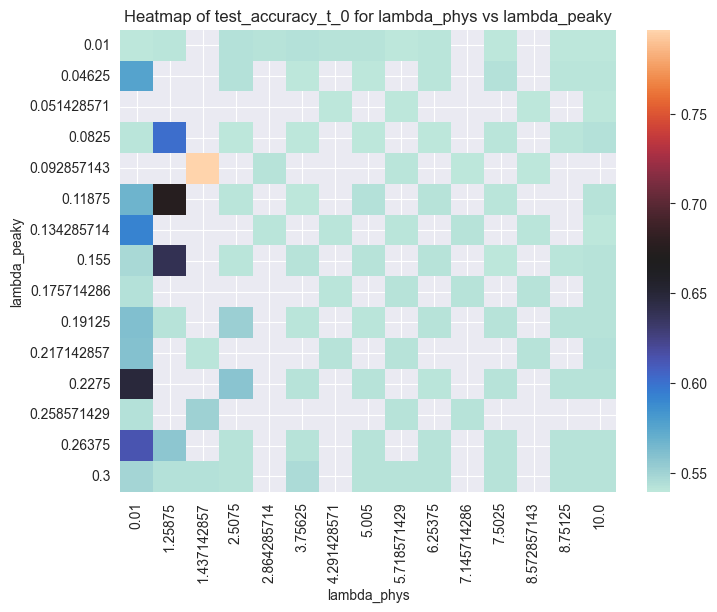

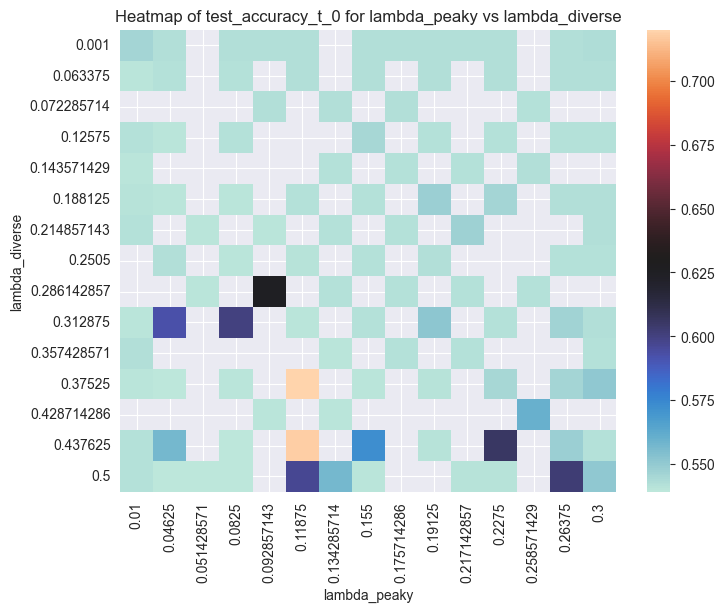

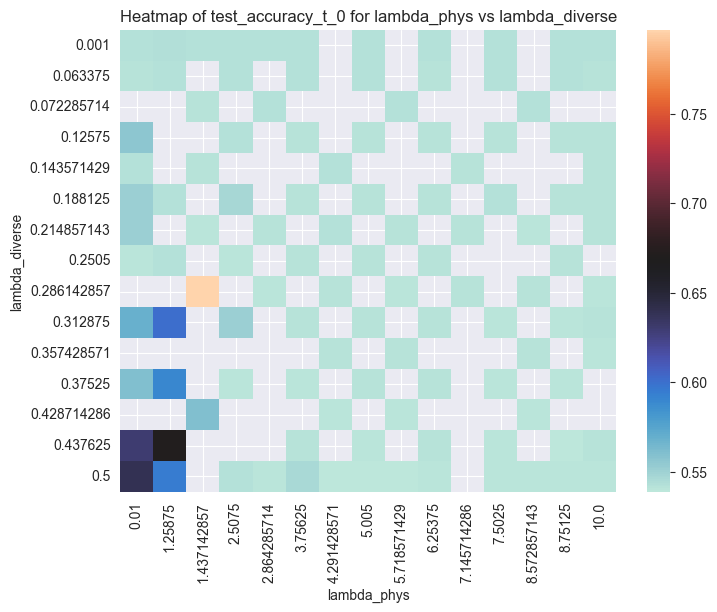

In [127]:
## 4. Heatmap of Accuracy for Pairs of Lambdas
def heatmap_for_lambdas(df, lambda_x, lambda_y, metric="test_accuracy_t_0"):
    pivot = df.pivot_table(values=metric, index=lambda_y, columns=lambda_x, aggfunc="mean")
    plt.figure(figsize=(8,6))
    sns.heatmap(pivot, annot=False, cmap="icefire")
    plt.title(f"Heatmap of {metric} for {lambda_x} vs {lambda_y}")
    plt.xlabel(lambda_x)
    plt.ylabel(lambda_y)
    plt.show()

heatmap_for_lambdas(df, lambda_cols[0], lambda_cols[1], "test_accuracy_t_0") #epoch_end
heatmap_for_lambdas(df, lambda_cols[1], lambda_cols[2], "test_accuracy_t_0")
heatmap_for_lambdas(df, lambda_cols[0], lambda_cols[2], "test_accuracy_t_0")



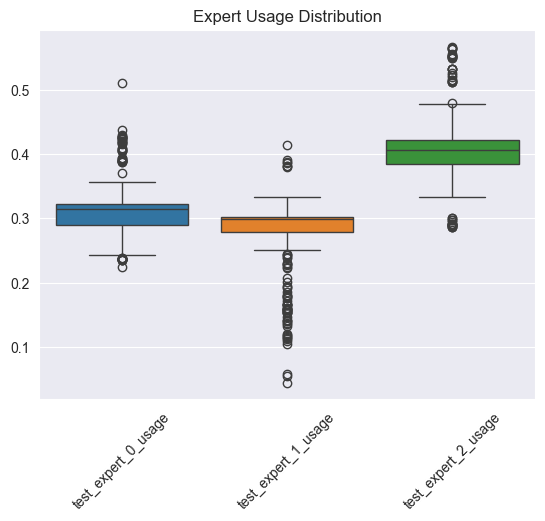

In [128]:
## 5. Expert Usage Distribution
sns.boxplot(data=df[expert_usage_cols])
plt.title("Expert Usage Distribution")
plt.xticks(rotation=45)
plt.show()


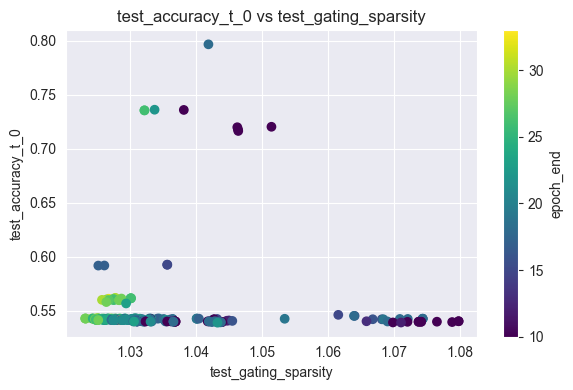

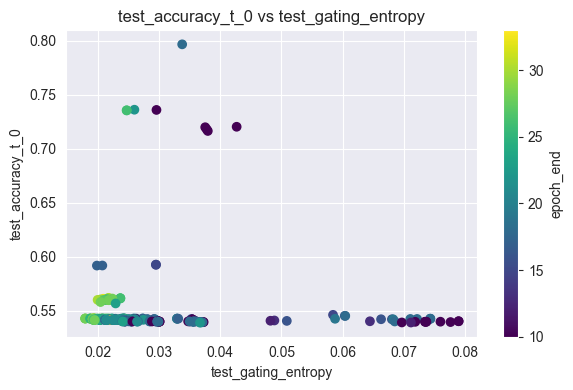

In [129]:
## 6. Gating Behavior vs Accuracy
for gate_col in gating_cols:
    fig, ax = plt.subplots(figsize=(6, 4))
    sc = ax.scatter(
        df[gate_col],
        df["test_accuracy_t_0"],
        c=df["epoch_end"],
        cmap="viridis"
    )
    ax.set_title(f"test_accuracy_t_0 vs {gate_col}")
    ax.set_xlabel(gate_col)
    ax.set_ylabel("test_accuracy_t_0")

    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label("epoch_end")

    plt.tight_layout()
    plt.show()


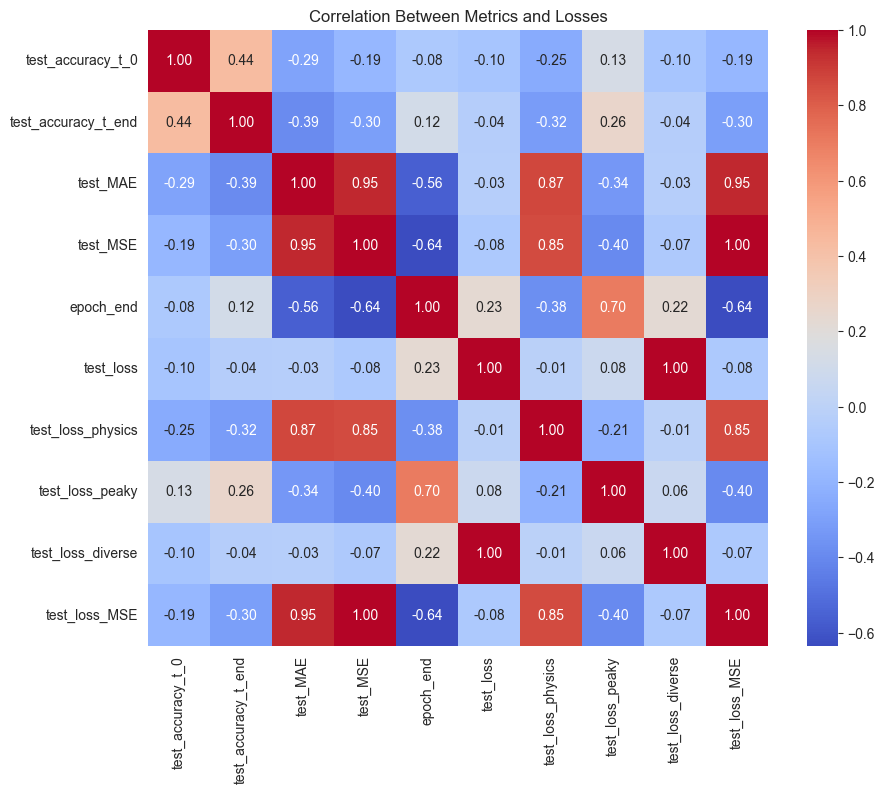

In [130]:
## 7. Correlation Heatmap
metrics_cols = ["test_accuracy_t_0", "test_accuracy_t_end", "test_MAE", "test_MSE", "epoch_end"] + loss_cols
corr = df[metrics_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Metrics and Losses")
plt.show()


In [132]:
## 8. Best Run Recommendation
# Score: accuracy_t_0 + accuracy_t_end - MAE - MSE
df["score"] = df["test_accuracy_t_0"] + df["test_accuracy_t_end"] - df["test_MAE"] - df["test_MSE"] + df["epoch_end"]/70
top_runs = df.sort_values("score", ascending=False).head(10)

display(top_runs[["run_id", "score", "test_accuracy_t_0", "test_accuracy_t_end", "test_MAE", "test_MSE", "epoch_end"] + lambda_cols])


,run_id,score,test_accuracy_t_0,test_accuracy_t_end,test_MAE,test_MSE,epoch_end,lambda_phys,lambda_peaky,lambda_diverse
4,utx2c00b,1.689170,0.735552,0.584720,0.002496,0.000034,26,0.010000,0.263750,0.500000
3,umrirjos,1.689170,0.735552,0.584720,0.002496,0.000034,26,0.010000,0.263750,0.500000
0,i84jxl7i,1.645588,0.796719,0.594441,0.002680,0.000035,18,1.437143,0.092857,0.286143
1,do3krbp2,1.632770,0.736153,0.584820,0.002451,0.000037,22,0.010000,0.227500,0.437625
203,z5n2ztw2,1.563293,0.541324,0.553050,0.002480,0.000030,33,2.507500,0.300000,0.250500
19,5qapqp5w,1.561320,0.561034,0.546035,0.002858,0.000034,32,3.756250,0.300000,0.500000
38,1ny37nub,1.553527,0.542861,0.584486,0.002363,0.000029,30,1.258750,0.300000,0.063375
24,btoacpqu,1.539941,0.559999,0.553818,0.002414,0.000033,30,0.010000,0.300000,0.375250
13,5fuokeb5,1.533615,0.561736,0.545868,0.002529,0.000030,30,1.258750,0.263750,0.500000
14,12quqjyo,1.533615,0.561736,0.545868,0.002529,0.000030,30,1.258750,0.263750,0.500000
